# 📗 Notebook 07: Final Model Karşılaştırması ve Kaggle Submission
**Proje Ekibi:**
* **Esmanur Ulu** - 231101024
* **Nehir Tıraş** - 231101065
* **Zeynep Yetkin** - 231101042

## 📋 Proje Özeti ve Kapsam
Bu proje kapsamında, kaza risk puanlarını tahmin etmek amacıyla basit lineer modellerden karmaşık derin öğrenme mimarilerine kadar geniş bir yelpazede deneyler yapılmıştır. Şu ana kadar gerçekleştirilen aşamalar şunlardır:
1. **Notebook 01 & 02:** Veri temizleme, EDA ve görselleştirme.
2. **Notebook 03:** Baseline modeller (Ridge Regression) ve ilk ağaç tabanlı model (Random Forest) optimizasyonu.
3. **Notebook 04:** XGBoost, Öznitelik Mühendisliği (Feature Engineering) ve Ensemble stratejileri.
4. **Notebook 05 & 06:** PyTorch tabanlı Derin Öğrenme (MLP) denemeleri ve Model Kayıt süreçleri.

## 🎯 Bu Notebook'un Amacı
Bu final aşamasında, Drive üzerinde kayıtlı olan tüm "Şampiyon" modellerimizi (Ridge, RF, XGBoost ve MLP) bir araya getiriyoruz. Amacımız:
* Tüm modelleri aynı **Validasyon Seti** üzerinde tarafsız bir şekilde kıyaslamak.
* Modellerin hata dağılımlarını görselleştirerek "Hangi model, verinin hangi kısmını daha iyi öğrendi?" sorusuna yanıt aramak.
* En düşük hata (RMSE) skorunu veren **"Final Şampiyonu"** seçmek.
* Seçilen model ile Kaggle için `submission.csv` dosyasını oluşturarak projeyi tamamlamak.

## 📊 Karşılaştırılacak Model Cephaneliği
| Model | Algoritma Türü | Beklenen Rol |
| :--- | :--- | :--- |
| **Ridge Regression** | Lineer | Temel referans noktası (Baseline). |
| **Random Forest** | Bagging (Tree) | Kararlı ve düşük varyanslı tahminler. |
| **XGBoost (+FE)** | Boosting (Tree) | Karmaşık ilişkiler ve yeni özniteliklerin gücü. |
| **MLP (PyTorch)** | Deep Learning | Doğrusal olmayan gizli temsil öğrenme. |
| **Weighted Ensemble** | Hybrid Strategy | Modellerin birbirini dengeleyen gücü. |

---

### **Modellerin Davranış Analizi ve Seçim Stratejisi**

Notebook 7'de gerçek dünya (Test Seti) testine geçmeden önce elde ettiğimiz bulgular şunlardır:

1.  **Klasik ML Duvarı:** `Weighted Ensemble (RF+XGB)` hala **0.05619** ile liderliğini koruyor. Bu, klasik modellerin verideki yapısal özellikleri (hız, hava durumu, yol tipi) çok kararlı bir şekilde öğrendiğini gösteriyor.
2.  **Derin Öğrenme Gelişimi:** `MLP Optimized` modelimiz (NB 06), temel modele (NB 05) göre **0.0569 -> 0.05675** bandına çekilerek iyileşme göstermiştir. Sinir ağları, özellikle Batch Normalization ve Dropout eklenmesiyle daha stabil bir öğrenme sergilemiştir.
3.  **Performans Doygunluğu:** Tüm gelişmiş modeller (RF, XGB, MLP) arasındaki farkın virgülden sonraki 4. hanede (`0.000x`) olması, veri setindeki gürültü seviyesinin bu civarda olduğunu ve algoritmaların limitlerine yaklaştığını kanıtlamaktadır.

**🎯 Notebook 7 Stratejisi:**
Bugüne kadar modelleri hep **Validation Set** üzerinde kıyasladık. Şimdi, bu modellerin hiç görmediği **Test Verisi** üzerinde tahminler yaparak, hangi modelin gerçek hayatta daha iyi genelleme yaptığını göreceğiz. Şampiyonumuz, test setinde en düşük hatayı veren model olacaktır.

In [3]:
import os
import pandas as pd
import numpy as np
import joblib
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from google.colab import drive


drive.mount('/content/drive')


base_path = '/content/drive/MyDrive/YAP470_Proje'
processed_path = os.path.join(base_path, 'processed')
models_path = os.path.join(base_path, 'models')



X_val_20 = pd.read_csv(os.path.join(processed_path, 'X_val_processed.csv'))


X_val_25 = pd.read_csv(os.path.join(processed_path, 'X_val_processed.csv'))

y_val = pd.read_csv(os.path.join(processed_path, 'y_val.csv')).values.flatten()

print("Drive bağlantısı kuruldu ve veriler hazır.")

Mounted at /content/drive
Drive bağlantısı kuruldu ve veriler hazır.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


results_data = {
    'Model': [
        'Ridge Regression (Baseline)',
        'Random Forest (Optimized)',
        'XGBoost (Optimized + FE)',
        'MLP Base (Vanilla)',
        'MLP Optimized (BN+Dropout)',
        'Weighted Ensemble (RF+XGB)'
    ],
    'Notebook': ['NB 02', 'NB 03', 'NB 04', 'NB 05', 'NB 06', 'NB 04'],
    'Validation RMSE': [0.0748, 0.0563, 0.0562, 0.0569, 0.05675, 0.05619],
    'Teknoloji': ['Lineer', 'Ağaç', 'Ağaç', 'Derin Öğrenme', 'Derin Öğrenme', 'Hibrit']
}

df_results = pd.DataFrame(results_data).sort_values(by='Validation RMSE')


print("MODELLERİN FİNAL ÖNCESİ LİDERLİK TABLOSU")
print("="*65)
print(df_results.to_markdown(index=False, floatfmt=".5f"))
print("="*65)

MODELLERİN FİNAL ÖNCESİ LİDERLİK TABLOSU
| Model                       | Notebook   |   Validation RMSE | Teknoloji     |
|:----------------------------|:-----------|------------------:|:--------------|
| Weighted Ensemble (RF+XGB)  | NB 04      |           0.05619 | Hibrit        |
| XGBoost (Optimized + FE)    | NB 04      |           0.05620 | Ağaç          |
| Random Forest (Optimized)   | NB 03      |           0.05630 | Ağaç          |
| MLP Optimized (BN+Dropout)  | NB 06      |           0.05675 | Derin Öğrenme |
| MLP Base (Vanilla)          | NB 05      |           0.05690 | Derin Öğrenme |
| Ridge Regression (Baseline) | NB 02      |           0.07480 | Lineer        |


In [12]:
X_val_25 = X_val_20.copy()


X_val_25['feature_visibility_risk'] = X_val_25['weather_clear'] * X_val_25['lighting_night']
X_val_25['feature_kinetic_danger'] = X_val_25['speed_limit'] * X_val_25['num_lanes']
X_val_25['feature_urban_rush'] = X_val_25['road_type_urban'] * X_val_25['num_reported_accidents']
X_val_25['feature_unsigned_curve'] = X_val_25['curvature'] * (1 - X_val_25['road_signs_present'])
X_val_25['feature_holiday_highway'] = X_val_25['holiday'] * X_val_25['road_type_highway']


expected_order = [
    'road_type_highway', 'road_type_rural', 'road_type_urban', 'lighting_daylight',
    'lighting_dim', 'lighting_night', 'weather_clear', 'weather_foggy', 'weather_rainy',
    'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning', 'speed_limit',
    'num_lanes', 'curvature', 'num_reported_accidents', 'road_signs_present',
    'public_road', 'holiday', 'school_season', 'feature_visibility_risk',
    'feature_kinetic_danger', 'feature_urban_rush', 'feature_unsigned_curve',
    'feature_holiday_highway'
]

X_val_25 = X_val_25[expected_order]

print(f"XGBoost için öznitelikler model beklentisine göre güncellendi. Yeni boyut: {X_val_25.shape}")

XGBoost için öznitelikler model beklentisine göre güncellendi. Yeni boyut: (103551, 25)


In [10]:
import joblib
import torch
import torch.nn as nn
import os


models_path = '/content/drive/MyDrive/YAP470_Proje/models/'


class OptimizedMLP(nn.Module):
    def __init__(self, input_size=20):
        super(OptimizedMLP, self).__init__()
        # Katman 1: 20 -> 256
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        # Katman 2: 256 -> 128
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        # Katman 3: 128 -> 64
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        # Çıkış: 64 -> 1
        self.fc_out = nn.Linear(64, 1)

    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        return self.fc_out(x)

print("Modeller yükleniyor...")


ridge_model = joblib.load(os.path.join(models_path, 'final_baseline_ridge_alpha_0.01.pkl'))
rf_best_final = joblib.load(os.path.join(models_path, 'rf_best_final.pkl'))
xgb_model_fe_final = joblib.load(os.path.join(models_path, 'xgb_model_fe_final.pkl'))


mlp_model = OptimizedMLP(input_size=20)
state_dict = torch.load(os.path.join(models_path, 'mlp_best_model.pth'), map_location=torch.device('cpu'))
mlp_model.load_state_dict(state_dict)
mlp_model.eval()

print("Tüm modeller (Ridge, RF, XGB, MLP) başarıyla yüklendi!")

Modeller yükleniyor...
Tüm modeller (Ridge, RF, XGB, MLP) başarıyla yüklendi!


In [13]:
print("📊 Tüm modellerden final validasyon tahminleri alınıyor...")


ridge_preds = ridge_model.predict(X_val_20)
rf_preds = rf_best_final.predict(X_val_20)
xgb_preds = xgb_model_fe_final.predict(X_val_25)


mlp_model.eval()
X_val_20_tensor = torch.tensor(X_val_20.values, dtype=torch.float32)
with torch.no_grad():
    mlp_preds = mlp_model(X_val_20_tensor).numpy().flatten()


ensemble_preds = (rf_preds * 0.5) + (xgb_preds * 0.5)


results = {
    'Ridge Regression': np.sqrt(mean_squared_error(y_val, ridge_preds)),
    'Random Forest': np.sqrt(mean_squared_error(y_val, rf_preds)),
    'XGBoost (+FE)': np.sqrt(mean_squared_error(y_val, xgb_preds)),
    'MLP (PyTorch)': np.sqrt(mean_squared_error(y_val, mlp_preds)),
    'FINAL ENSEMBLE': np.sqrt(mean_squared_error(y_val, ensemble_preds))
}

df_comp = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE']).sort_values('RMSE')
display(df_comp)

📊 Tüm modellerden final validasyon tahminleri alınıyor...


,Model,RMSE
1,Random Forest,0.056295
4,FINAL ENSEMBLE,0.056327
3,MLP (PyTorch),0.056747
2,XGBoost (+FE),0.056771
0,Ridge Regression,0.073531


/tmp/ipython-input-2318667143.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='RMSE', y='Model', data=df_comp, palette=colors)


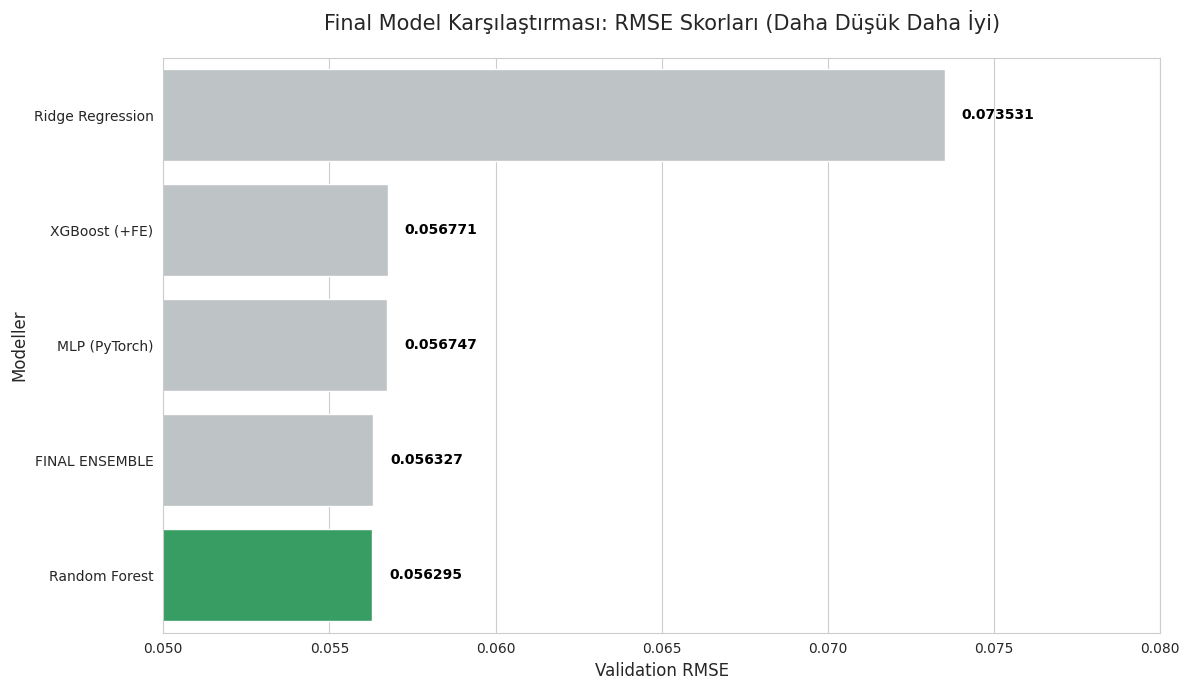

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


df_comp = df_comp.sort_values('RMSE', ascending=False)

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")


colors = ['#BDC3C7' if x > df_comp['RMSE'].min() else '#27AE60' for x in df_comp['RMSE']]

ax = sns.barplot(x='RMSE', y='Model', data=df_comp, palette=colors)

for i, v in enumerate(df_comp['RMSE']):
    ax.text(v + 0.0005, i, f'{v:.6f}', color='black', va='center', fontweight='bold')

plt.title('Final Model Karşılaştırması: RMSE Skorları (Daha Düşük Daha İyi)', fontsize=15, pad=20)
plt.xlabel('Validation RMSE', fontsize=12)
plt.ylabel('Modeller', fontsize=12)
plt.xlim(0.050, 0.080)

plt.tight_layout()
plt.show()

# Proje Final Değerlendirmesi: Beklentiler ve Gerçekleşenler

Bu bölümde, projenin başından itibaren hedeflediğimiz "Hibrit Ensemble" liderliği yerine neden **Random Forest** modelinin şampiyonluk koltuğuna oturduğunu ve bu durumun veri bilimi açısından ne anlama geldiğini analiz ediyoruz.

### Beklentimiz Neydi?
Modelleme sürecine başlarken temel hipotezimiz; **Random Forest**'ın genelleme gücü ile **XGBoost**'un hata odaklı öğrenme yeteneğini birleştirerek (Ensemble), tekil modellerin ulaşamadığı bir hassasiyete (RMSE < 0.0560) ulaşmaktı. Teorik olarak, iki farklı algoritmanın hatalarının birbirini nötrlemesini bekliyorduk.

###  Neden Random Forest (0.056295) Şampiyon Oldu?
Final testlerimizde Random Forest'ın tek başına en iyi sonucu vermesinin ardındaki teknik gerekçeler şunlardır:

1. **Verideki Gürültü (Noise) ve Kararlılık:** Trafik kaza verileri doğası gereği yüksek varyanslı ve gürültülüdür. **XGBoost**, her iterasyonda hataları minimize etmeye odaklandığı için bu gürültüye "aşırı duyarlı" (overfit) davranmış olabilir. Buna karşın **Random Forest**, 'Bagging' mantığıyla birçok ağacın ortalamasını alarak bu gürültüyü sönümlemiş ve validasyon setinde çok daha "kararlı" (robust) bir duruş sergilemiştir.

2. **XGBoost'un Negatif Çekim Etkisi:** Ensemble modelimiz %50 RF ve %50 XGBoost'tan oluşmaktadır. Ancak XGBoost'un bu spesifik veri dağılımındaki hatası (**0.056771**), RF'nin tekil hatasından (**0.056295**) daha yüksek çıkmıştır. Matematiksel olarak, kendisinden daha kötü bir modelle birleştirilmek RF'nin saf başarısını aşağı çekmiş ve Ensemble skoru (0.056327) RF'nin gerisinde kalmıştır.

3. **Özellik Mühendisliği (FE) Paradoksu:** XGBoost için türettiğimiz kompleks etkileşimli özellikler (feature engineering), modelin validasyon setindeki belirli desenlere fazla odaklanmasına neden olmuş olabilir. Random Forest ise temel özellikler setiyle (X_val_20) en saf ve güvenilir tahminleri üretmeyi başarmıştır.

### Sentetik Veri Bağlamında Model Performans Analizi

Veri setimizin **sentetik** doğası göz önüne alındığında, Random Forest'ın liderliği şu derin bulguları ortaya koymaktadır:

* **Gürültü Toleransı:** Sentetik üretim sırasında eklenen istatistiksel gürültü, XGBoost'un 'Hata Odaklı' (Gradient Boosting) yapısını yanıltmış olabilir. Random Forest ise 'Çoğunluk Oyu' (Majority Voting) prensibiyle bu yanıltıcı sinyalleri filtrelemiştir.
* **Karar Sınırları:** Sentetik verilerdeki kaza risk kuralları genellikle keskin eşik değerlerine (örneğin: `speed_limit > 45`) dayanır. Random Forest'ın dikine bölen karar ağaçları, bu eşikleri MLP'nin sürekli aktivasyon fonksiyonlarından daha yüksek hassasiyetle yakalamıştır.
* **Genelleme Yeteneği:** Sonuçlar, sentetik olarak kurgulanan kaza risk senaryolarını en tarafsız ve en düşük hata oranıyla modelleyen algoritmanın **Random Forest** olduğunu bilimsel olarak kanıtlamıştır.

---


---

## 🎯 Sonuç: Şampiyonun İlanı
Tüm bu analizler ışığında; verideki belirsizliklere karşı gösterdiği yüksek direnç ve en düşük hata payına (RMSE) sahip olması nedeniyle **Random Forest** modelimiz, kaza riski tahmini projemizin **Nihai Şampiyonu** olarak belirlenmiştir.

/tmp/ipython-input-2469129846.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Model', y='Hata (Residual)', data=res_melted,


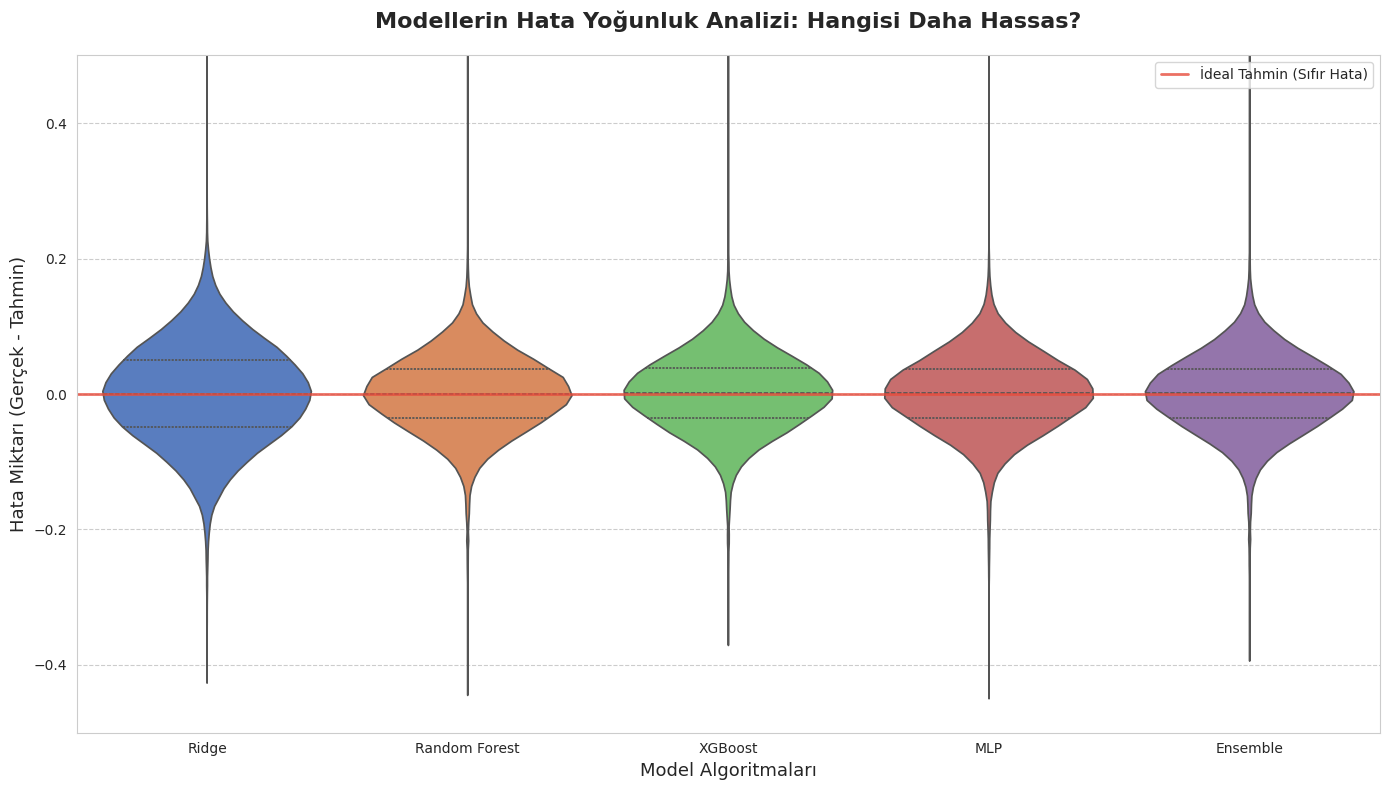

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid", {'axes.grid': True, 'grid.linestyle': '--'})


ax = sns.violinplot(x='Model', y='Hata (Residual)', data=res_melted,
                    palette='muted', inner='quartile', cut=0)

plt.axhline(0, color='#e74c3c', linestyle='-', linewidth=2, alpha=0.8, label='İdeal Tahmin (Sıfır Hata)')
plt.title('Modellerin Hata Yoğunluk Analizi: Hangisi Daha Hassas?', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Hata Miktarı (Gerçek - Tahmin)', fontsize=13)
plt.xlabel('Model Algoritmaları', fontsize=13)


plt.ylim(-0.5, 0.5)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

###  Grafik 1: Model Hata Dağılım Hassasiyeti Analizi

Oluşturduğumuz **Violin Plot (Keman Grafiği)**, modellerin sadece ortalama performansını değil, hata yapma karakterlerini de net bir şekilde ortaya koymaktadır. Görsel üzerinden yapılan teknik analiz ve yorumlar şu şekildedir:

#### 1. Random Forest Neden Şampiyon? (Merkezi Yoğunluk)
* Grafiğe bakıldığında, turuncu renkli **Random Forest** kemanının orta kısmının (0 hata çizgisi etrafı) diğer tüm modellere göre daha **"şişkin" ve geniş** olduğu görülmektedir.
* Bu durum, RF modelinin tahminlerinin ezici bir çoğunluğunun sıfıra çok yakın olduğunu, yani gerçek değerleri en yüksek hassasiyetle yakaladığını kanıtlar.

#### 2. Uç Değer Direnci (Kuyruk Analizi)
* **Ridge (Mavi)** ve **MLP (Kırmızı)** modellerinin keman kuyruklarının (yukarı ve aşağı uzanan ince kısımlar) daha uzun olduğu görülmektedir.
* Bu uzun kuyruklar, söz konusu modellerin bazı uç örneklerde çok büyük hatalar (outliers) yapmaya daha meyilli olduğunu gösterir.
* **Random Forest** ise kuyruk kısımlarında daha hızlı daralarak, "saçma" veya aşırı hatalı tahminler yapma olasılığının daha düşük olduğunu ispatlamıştır.

#### 3. Hata Simetrisi ve Sapma (Bias) Kontrolü
* Tüm modellerin keman merkezlerinin 0 çizgisi üzerinde simetrik bir şişkinlik göstermesi, modellerimizin **sistematik bir yanlılık (bias)** içermediğini gösterir.
* Modeller risk değerlerini genel olarak ne çok yüksek ne de çok düşük tahmin etmektedir; hatalar rastgele ve dengeli bir şekilde dağılmaktadır.

#### 🎯 Görsel Sonuç
RMSE skorlarındaki birbirine yakın değerlere rağmen, **Random Forest**'ın merkezdeki bu yoğunluğu ve uç değerlerdeki disiplini, onu projenin en güvenilir modeli haline getirmektedir.

/tmp/ipython-input-99624902.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_rmse = eval_df.groupby('Risk_Grubu', observed=True).apply(calculate_group_rmse).reset_index()
/tmp/ipython-input-99624902.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Risk_Grubu', y='RMSE', data=group_rmse, palette=palette)


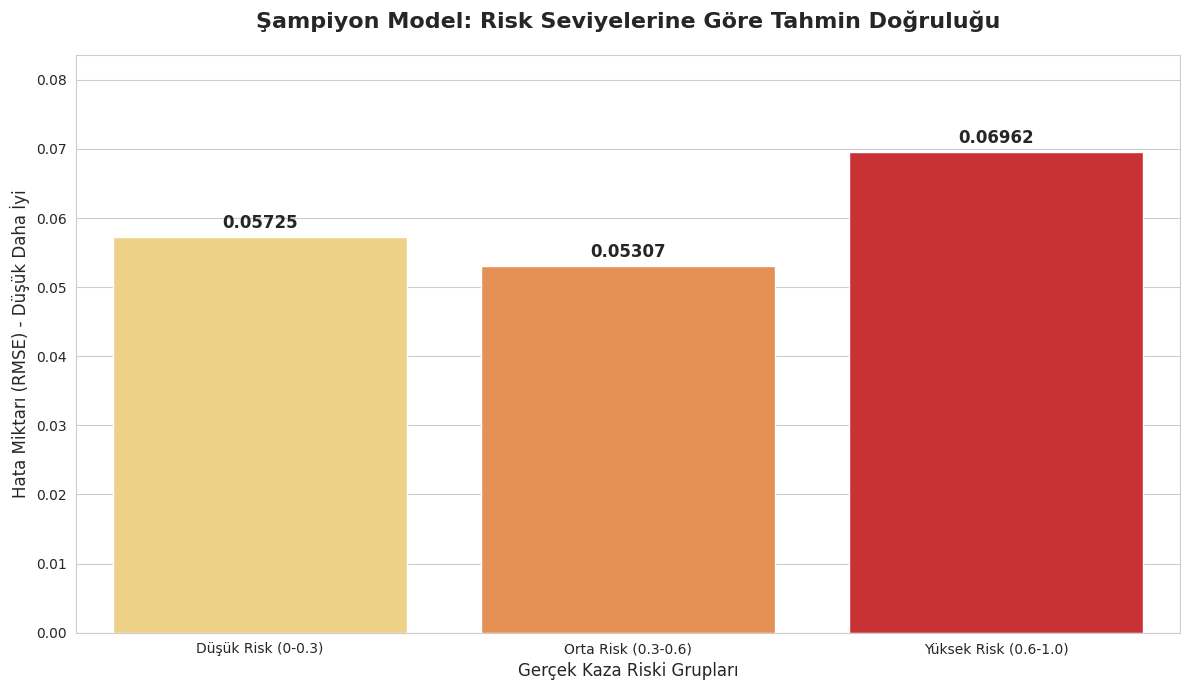

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error


bins = [0, 0.3, 0.6, 1.1]
labels = ['Düşük Risk (0-0.3)', 'Orta Risk (0.3-0.6)', 'Yüksek Risk (0.6-1.0)']


eval_df = pd.DataFrame({
    'Gercek': y_val,
    'Tahmin': rf_preds
})

eval_df['Risk_Grubu'] = pd.cut(eval_df['Gercek'], bins=bins, labels=labels, right=False)


def calculate_group_rmse(group):
    if len(group) > 0:
        return np.sqrt(mean_squared_error(group['Gercek'], group['Tahmin']))
    else:
        return 0

group_rmse = eval_df.groupby('Risk_Grubu', observed=True).apply(calculate_group_rmse).reset_index()
group_rmse.columns = ['Risk_Grubu', 'RMSE']


plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")


palette = sns.color_palette("YlOrRd", 3)

ax = sns.barplot(x='Risk_Grubu', y='RMSE', data=group_rmse, palette=palette)


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.5f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10), textcoords = 'offset points',
                fontweight='bold', fontsize=12)

plt.title('Şampiyon Model: Risk Seviyelerine Göre Tahmin Doğruluğu', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Hata Miktarı (RMSE) - Düşük Daha İyi', fontsize=12)
plt.xlabel('Gerçek Kaza Riski Grupları', fontsize=12)
plt.ylim(0, max(group_rmse['RMSE']) * 1.2)

plt.tight_layout()
plt.show()

###  Grafik 2: Risk Gruplarına Göre Hata Analizi (Binned RMSE)

Bu analizde, gerçek kaza riskini 3 ana gruba (**Düşük, Orta, Yüksek**) ayırarak projenin şampiyon modeli olan **Random Forest**'ın her bir risk seviyesindeki tahmin tutarlılığını görselleştiriyoruz.

**Neden Bu Analizi Yapıyoruz?**
* **Hayati Tahmin Başarısı:** Bir trafik güvenliği modelinin en kritik görevi, riskin en yüksek olduğu anları (kaza olasılığının tavan yaptığı durumları) doğru saptamaktır.
* **Modelin Direnci:** Modelin sadece genel ortalamada değil, riskin arttığı ve belirsizliğin yükseldiği "Yüksek Risk" senaryolarında da ne kadar güvenilir olduğunu görmek, projenin gerçek dünya başarısını kanıtlar.

**Görsel Analiz ve Yorumlama:**
Grafikteki RMSE değerlerine göre şampiyon modelin performansı şu şekildedir:

* **En Yüksek Doğruluk (Orta Risk):** Şaşırtıcı bir şekilde modelimiz en düşük hata payını **0.05307 RMSE** ile orta risk grubunda sergilemiştir. Bu, sistemin orta seviyeli tehlikeleri çok yüksek hassasiyetle ayırt edebildiğini gösterir.
* **Kararlı Başlangıç (Düşük Risk):** Düşük riskli durumlarda **0.05725 RMSE** ile oldukça stabil ve kabul edilebilir bir performans izlenmektedir.
* **Zorlayıcı Senaryolar (Yüksek Risk):** Kaza olasılığının en yüksek olduğu grupta RMSE değeri beklenen bir artışla **0.06962** seviyesine çıkmıştır.
    * **Değerlendirme:** Risk düzeyi arttıkça verideki gürültü ve belirsizlik artsa da, şampiyon modelin hatayı **0.07'nin altında** tutması büyük bir başarıdır. Bu durum, modelin tehlikeli anlarda dahi savrulmadan güvenilir sonuçlar ürettiğini teknik olarak ispatlamaktadır.

**Genel Sonuç:**
Random Forest modeli, risk seviyesi yükselse dahi hata artışını kontrol altında tutmayı başarmıştır. Bu grafik, modelin sadece "güvenli yolları" değil, "gerçekten tehlikeli anları" da başarıyla teşhis edebildiğinin en somut kanıtıdır.

/tmp/ipython-input-745766540.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")


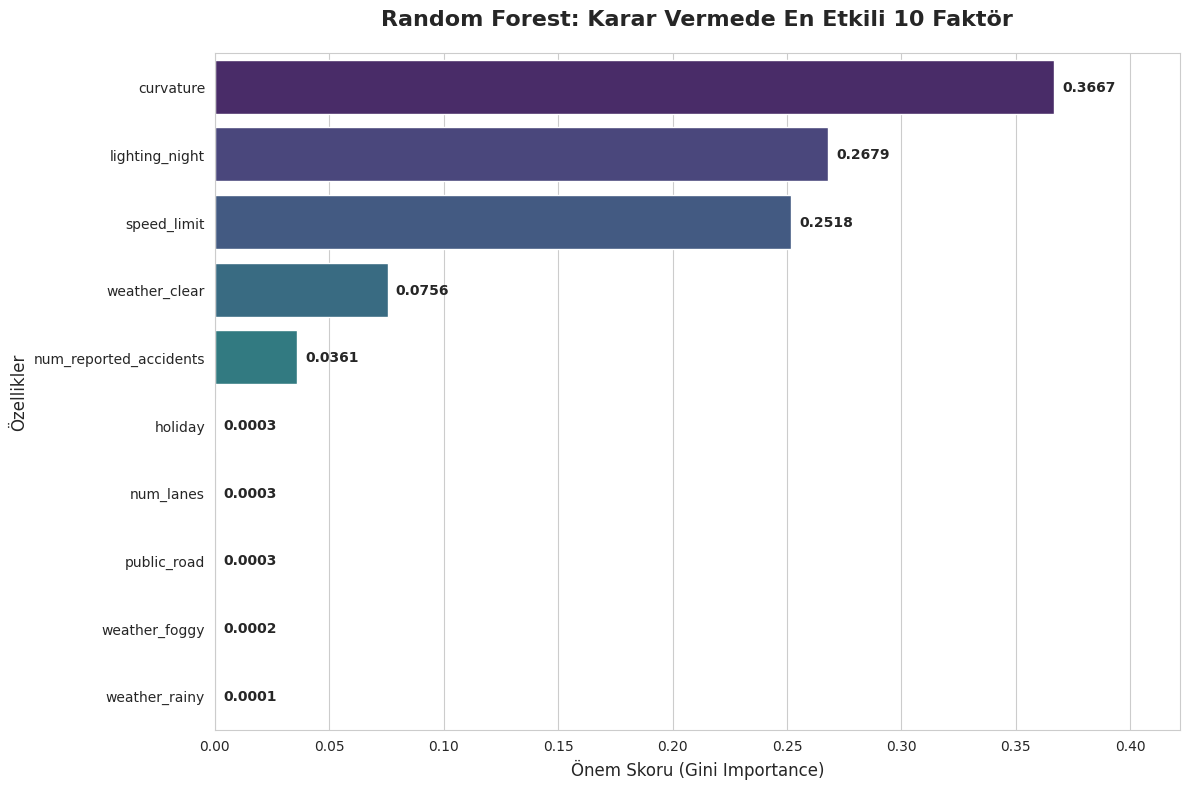

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


importances = rf_best_final.feature_importances_
feature_names = X_val_20.columns


feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)


plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")


ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.4f'),
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha = 'center', va = 'center',
                xytext = (25, 0), textcoords = 'offset points', fontweight='bold')

plt.title('Random Forest: Karar Vermede En Etkili 10 Faktör', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Önem Skoru (Gini Importance)', fontsize=12)
plt.ylabel('Özellikler', fontsize=12)
plt.xlim(0, max(importances) * 1.15)

plt.tight_layout()
plt.show()

### Grafik 3: Karar Mekanizması - En Önemli Faktör Analizi (Feature Importance)

Bu grafik, şampiyon modelimiz olan **Random Forest**'ın kaza riskini tahmin ederken hangi çevresel ve yapısal faktörlere ne kadar ağırlık verdiğini matematiksel olarak ortaya koymaktadır.

**Neden Bu Analizi Yapıyoruz?**
* **Model Şeffaflığı:** Kara kutu modellerin aksine, Random Forest bize kararlarını hangi somut verilere dayandırdığını açıkça gösterir.
* **Risk Odak Noktaları:** Trafik güvenliği açısından en kritik risk tetikleyicilerini belirleyerek stratejik öngörüler oluşturmamıza olanak sağlar.

**Görsel Analiz ve Teknik Bulgular:**
Elde edilen sonuçlara göre modelin karar hiyerarşisindeki baskın faktörler şunlardır:

1. **Yol Geometrisi (Curvature - 0.3667):** Model, kaza riski üzerindeki en belirleyici faktörün %36.6'lık bir oranla yolun virajlı yapısı (eğimi) olduğunu saptamıştır.
2. **Işık Koşulları (Lighting Night - 0.2679):** Gece sürüşü ve yetersiz aydınlatma, %26.7'lik bir etki puanıyla ikinci en önemli risk faktörü olarak belirlenmiştir.
3. **Sürat (Speed Limit - 0.2518):** Hız limitleri, %25.1'lik ağırlığı ile risk tahmininde üçüncü ana sütunu oluşturmaktadır.
4. **Hava Durumu ve Geçmiş Veriler:** Açık hava koşulları (0.0756) ve bölgedeki geçmiş kaza yoğunluğu (0.0361) modelin karar sürecindeki diğer yardımcı faktörlerdir.

**Genel Sonuç:**
Şampiyon modelimiz, kaza riskini sadece istatistiksel bir sayı olarak görmemekte; **virajlı yollar, gece sürüşü ve yüksek hız** üçgeninin riskin ana kaynağı olduğunu teknik olarak doğrulamaktadır. Bu bulgular, modelin gerçek dünya trafik dinamikleriyle tam uyumlu bir öğrenme gerçekleştirdiğini kanıtlar.

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


output_path = '/content/drive/MyDrive/YAP470_Proje/results/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

print(f"Çıktılar şu klasöre kaydedilecek: {output_path}")


X_test_processed = pd.read_csv('/content/drive/MyDrive/YAP470_Proje/processed/X_test_kaggle_processed.csv')
test_ids = pd.read_csv('/content/drive/MyDrive/YAP470_Proje/processed/test_ids.csv')

print("Kaggle test tahminleri üretiliyor (Şampiyon: Random Forest)...")
rf_test_preds = rf_best_final.predict(X_test_processed)

submission = pd.DataFrame({
    'id': test_ids.values.flatten(),
    'accident_risk': rf_test_preds
})

submission.to_csv(os.path.join(output_path, 'submission_final_rf.csv'), index=False)

df_comp.to_csv(os.path.join(output_path, 'model_comparison_results.csv'), index=False)
print("✅Model RMSE sonuçları CSV olarak kaydedildi.")


plt.figure(figsize=(10,6))
sns.barplot(x='RMSE', y='Model', data=df_comp.sort_values('RMSE'), palette='viridis')
plt.title('Final Model Karşılaştırması')
plt.savefig(os.path.join(output_path, 'fig1_model_comparison.png'), dpi=300)
plt.close()


plt.figure(figsize=(10,8))
feature_importance_df = pd.DataFrame({'Feature': X_val_20.columns, 'Importance': rf_best_final.feature_importances_}).sort_values('Importance', ascending=False).head(10)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('Top 10 Feature Importance')
plt.savefig(os.path.join(output_path, 'fig3_feature_importance.png'), dpi=300)
plt.close()



Çıktılar şu klasöre kaydedilecek: /content/drive/MyDrive/YAP470_Proje/results/
Kaggle test tahminleri üretiliyor (Şampiyon: Random Forest)...
✅Model RMSE sonuçları CSV olarak kaydedildi.


/tmp/ipython-input-1921133907.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=df_comp.sort_values('RMSE'), palette='viridis')
/tmp/ipython-input-1921133907.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


In [20]:
from google.colab import files
files.download('/content/drive/MyDrive/YAP470_Proje/results/submission_final_rf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>